# **Task 2: Training from scratch: images**

In [1]:
# necessary imports
import os
import glob
import numpy
import pandas
import random
import trimesh
import logging
import tensorflow
from PIL import Image
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, regularizers, optimizers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D

# import Stratified K-Fold Cross Validation notebook
%run KFold-Cross-Validation.ipynb

# dataset root path
DATASET_ROOT = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/dataset/'

# final preprocessed dataset directory path
DATASET_PATH = os.path.join(DATASET_ROOT, 'Preprocessed')

# number of classes for the classification task
NUM_CLASSES = 5

In [2]:
# only log critical messages
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## Input Target Size

In [3]:
# loop through images, load and store size
images_sizes = []
for image_filename in images_X['filename']:
    if image_filename != 'filename':
        image = Image.open(image_filename)
        images_sizes.append(image.size)

# convert to np array
images_sizes = numpy.array(images_sizes)

# print statistics
print("Loaded images: " + str(len(images_sizes)))
print("Average size: " + str(numpy.average(images_sizes, axis=0)))

Loaded images: 9270
Average size: [512. 512.]


In [4]:
# target size
TARGET_SIZE = (128, 128)

## Experiment 0 - Simple Model

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.


2022-02-14 23:56:17.781846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 23:56:17.799515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 23:56:17.799633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 23:56:17.800468: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "Experiment-0-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 32)             

2022-02-14 23:56:19.306952: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


  1/239 [..............................] - ETA: 6:52 - loss: 1.6063 - accuracy: 0.2500

2022-02-14 23:56:19.996538: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


239/239 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.6837
Epoch 00001: val_loss improved from inf to 0.64253, saving model to saved_models/images/Experiment-0/Experiment-0-fold-1.h5
239/239 [==============================] - 34s 137ms/step - loss: 0.9645 - accuracy: 0.6837 - val_loss: 0.6425 - val_accuracy: 0.7915
Epoch 2/50
239/239 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.8419
Epoch 00002: val_loss improved from 0.64253 to 0.50670, saving model to saved_models/images/Experiment-0/Experiment-0-fold-1.h5
239/239 [==============================] - 33s 140ms/step - loss: 0.4624 - accuracy: 0.8419 - val_loss: 0.5067 - val_accuracy: 0.8275
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.9109
Epoch 00003: val_loss did not improve from 0.50670
239/239 [==============================] - 33s 140ms/step - loss: 0.2740 - accuracy: 0.9109 - val_loss: 0.5072 - val_accuracy: 0.8510
Epoch 4/50
239/239

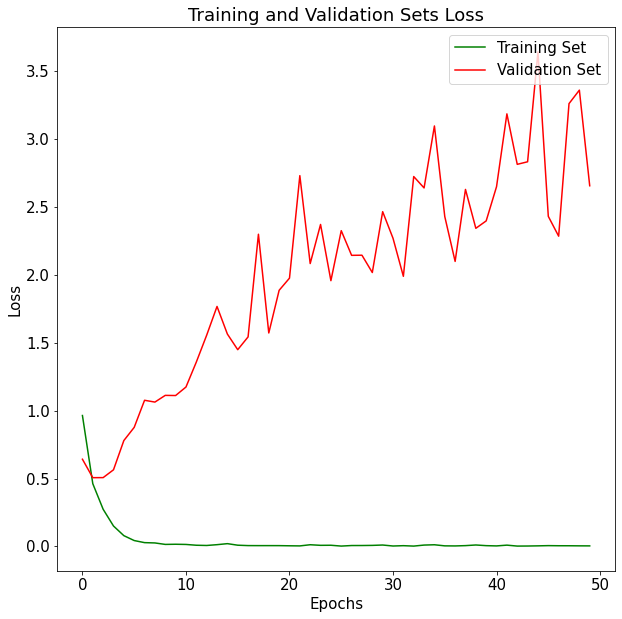

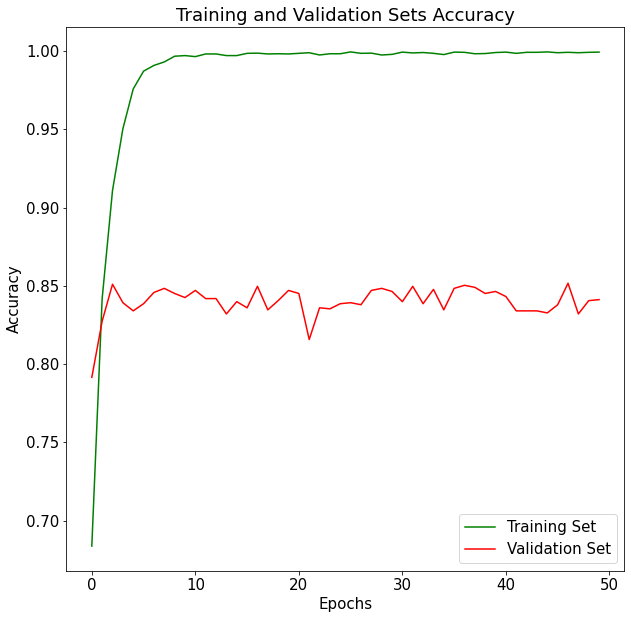

3/3 [==============================] - 0s 119ms/step - loss: 0.5906 - accuracy: 0.8387
Best model Test Loss: 0.5905967354774475
Best model Test Accuracy: 0.8387096524238586
Confusion Matrix
Normalized confusion matrix


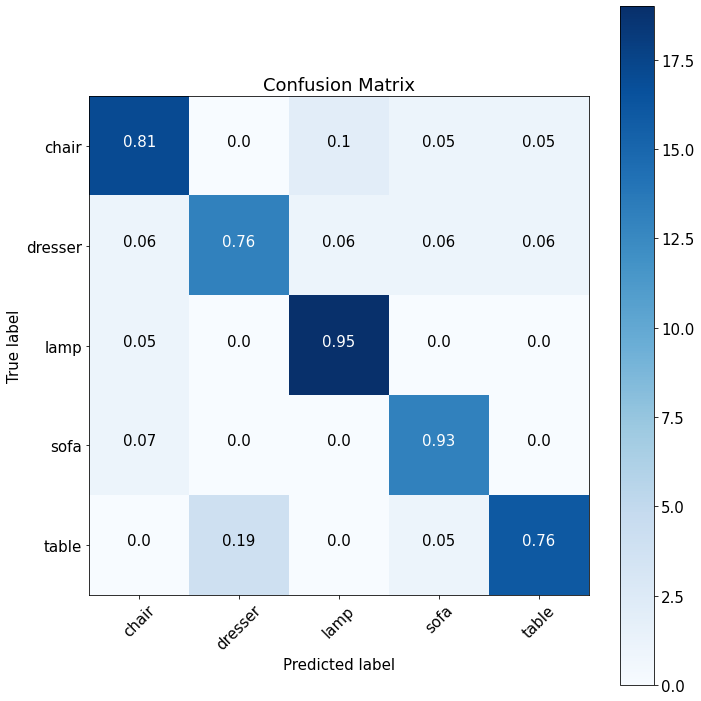

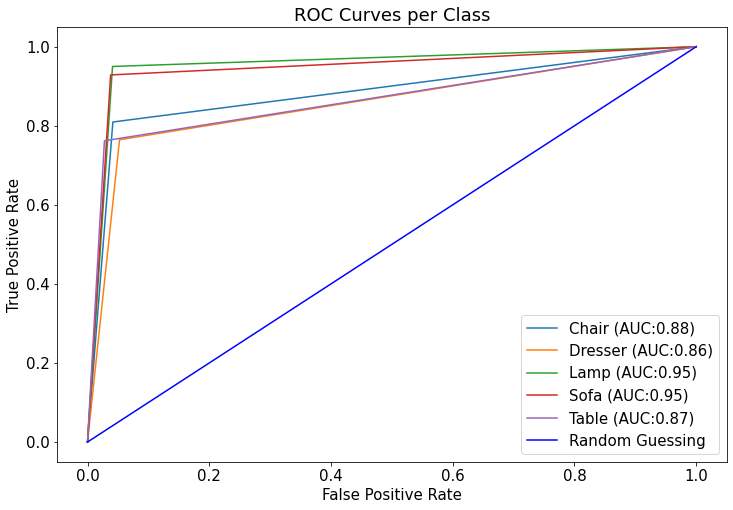

ROC AUC score: 0.9013559285005865
Classification Report
              precision    recall  f1-score   support

       chair       0.85      0.81      0.83        21
     dresser       0.76      0.76      0.76        17
        lamp       0.86      0.95      0.90        20
        sofa       0.81      0.93      0.87        14
       table       0.89      0.76      0.82        21

    accuracy                           0.84        93
   macro avg       0.84      0.84      0.84        93
weighted avg       0.84      0.84      0.84        93


-------- TERMINATED FOLD: 1 --------


In [5]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-0", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=50,
                        batch_size=32, one_fold=True, resample_data=0, augment=False)

## Experiment 1 - Dropout

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-1-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                 

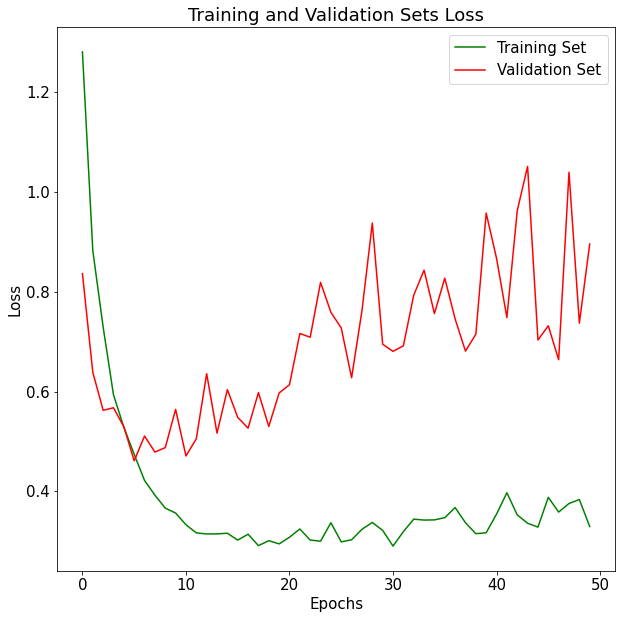

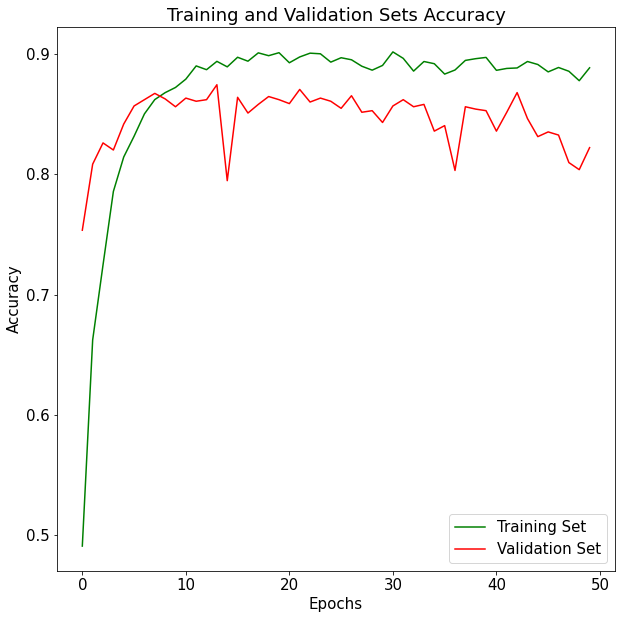

3/3 [==============================] - 0s 120ms/step - loss: 0.3668 - accuracy: 0.8710
Best model Test Loss: 0.36679890751838684
Best model Test Accuracy: 0.8709677457809448
Confusion Matrix
Normalized confusion matrix


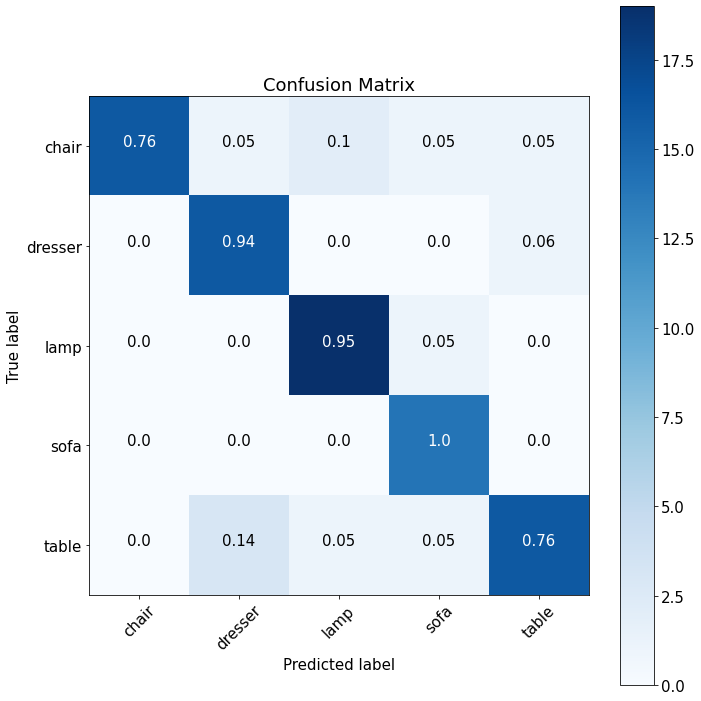

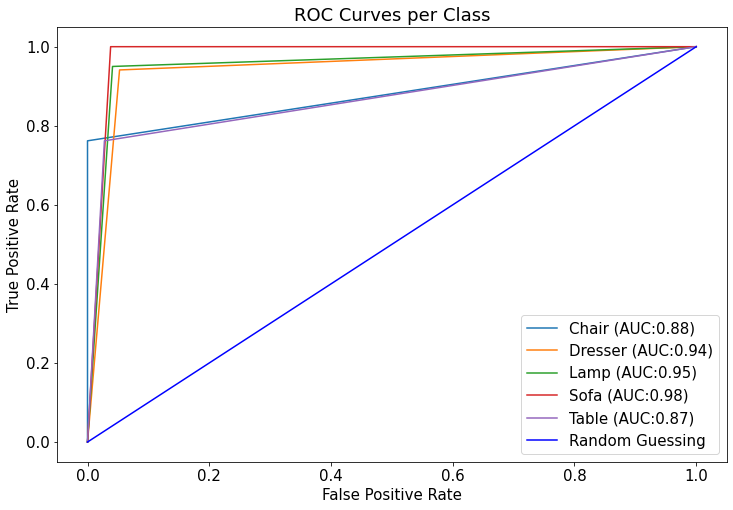

ROC AUC score: 0.925550606371735
Classification Report
              precision    recall  f1-score   support

       chair       1.00      0.76      0.86        21
     dresser       0.80      0.94      0.86        17
        lamp       0.86      0.95      0.90        20
        sofa       0.82      1.00      0.90        14
       table       0.89      0.76      0.82        21

    accuracy                           0.87        93
   macro avg       0.88      0.88      0.87        93
weighted avg       0.88      0.87      0.87        93


-------- TERMINATED FOLD: 1 --------


In [6]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-1", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=50,
                        batch_size=32, one_fold=True, resample_data=0, augment=False)

## Experiment 2 - Larger Model
#### Starting from this experiment, the number of training epochs is gradually increased from `50` to `200`.

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-2-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                 

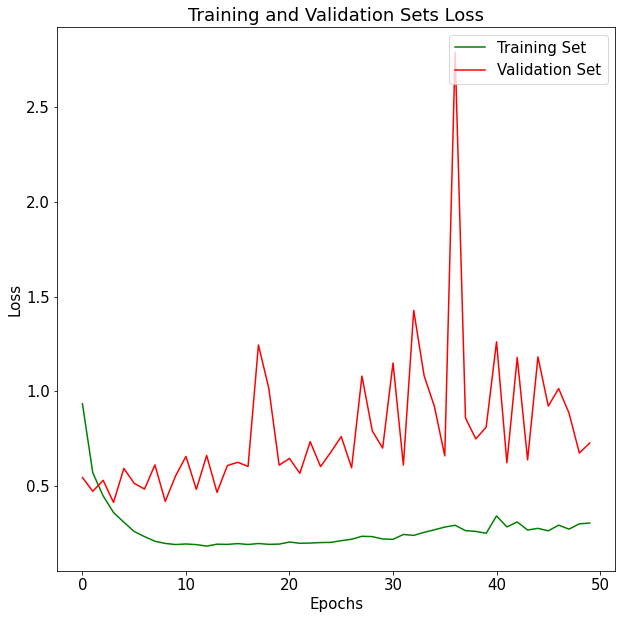

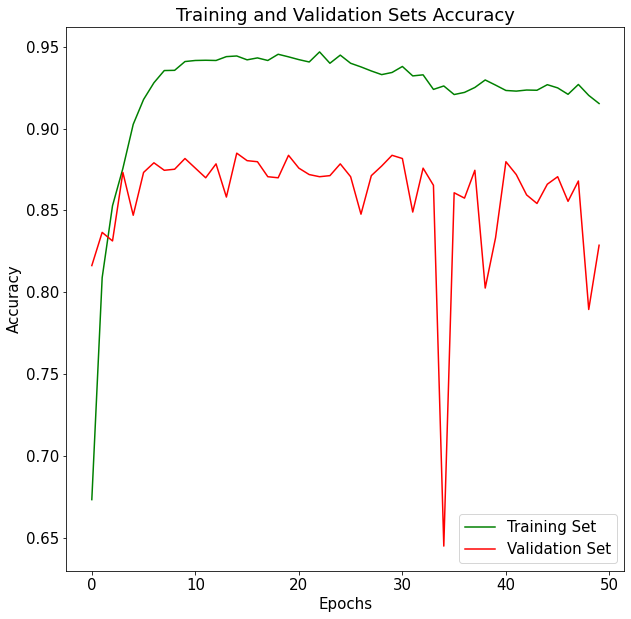

3/3 [==============================] - 0s 124ms/step - loss: 0.5023 - accuracy: 0.8495
Best model Test Loss: 0.5022757053375244
Best model Test Accuracy: 0.8494623899459839
Confusion Matrix
Normalized confusion matrix


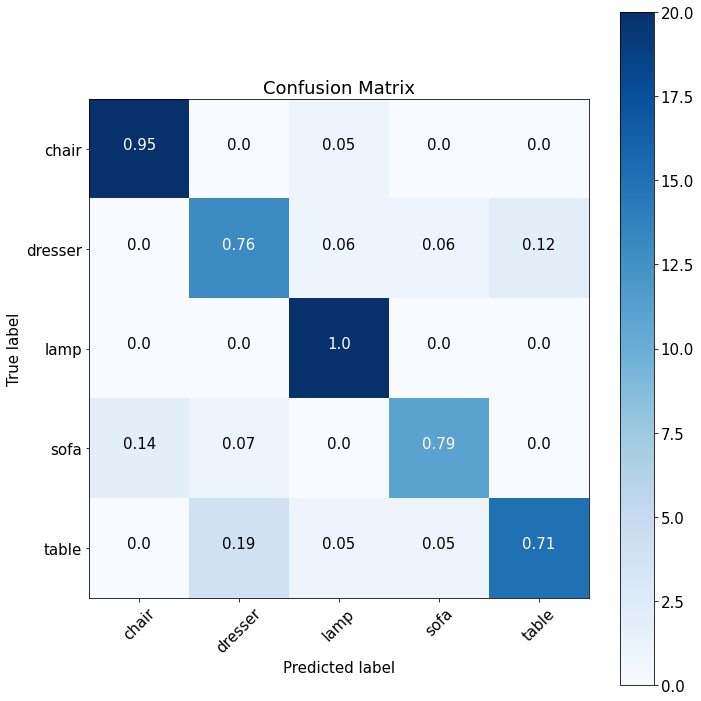

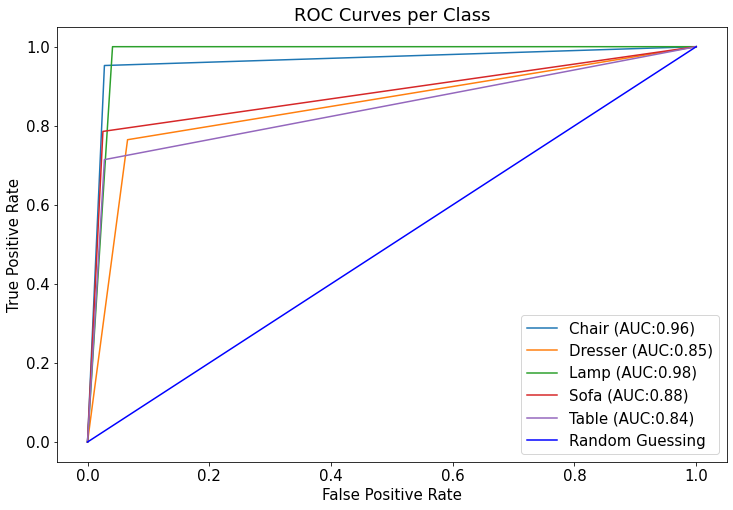

ROC AUC score: 0.9029329459386967
Classification Report
              precision    recall  f1-score   support

       chair       0.91      0.95      0.93        21
     dresser       0.72      0.76      0.74        17
        lamp       0.87      1.00      0.93        20
        sofa       0.85      0.79      0.81        14
       table       0.88      0.71      0.79        21

    accuracy                           0.85        93
   macro avg       0.85      0.84      0.84        93
weighted avg       0.85      0.85      0.85        93


-------- TERMINATED FOLD: 1 --------


In [7]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-2", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=50,
                        batch_size=32, one_fold=True, resample_data=0, augment=False)

## Experiment 3 - Data Augmentation, Longer Training

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-3-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                 

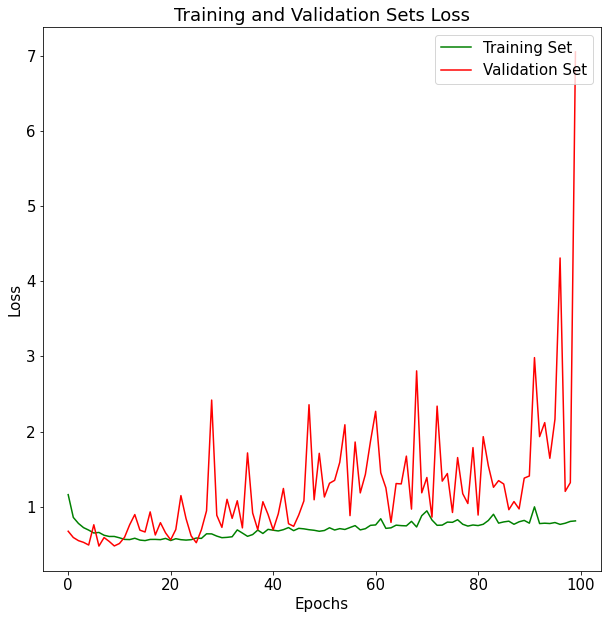

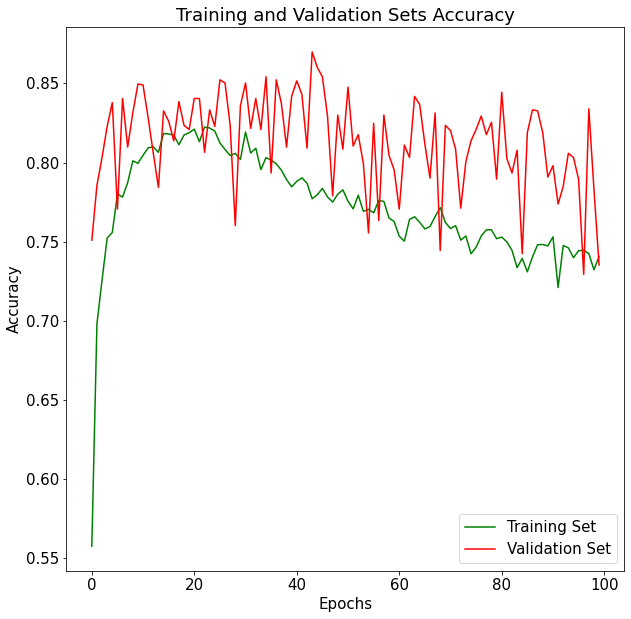

3/3 [==============================] - 0s 114ms/step - loss: 0.5479 - accuracy: 0.8602
Best model Test Loss: 0.5479267835617065
Best model Test Accuracy: 0.8602150678634644
Confusion Matrix
Normalized confusion matrix


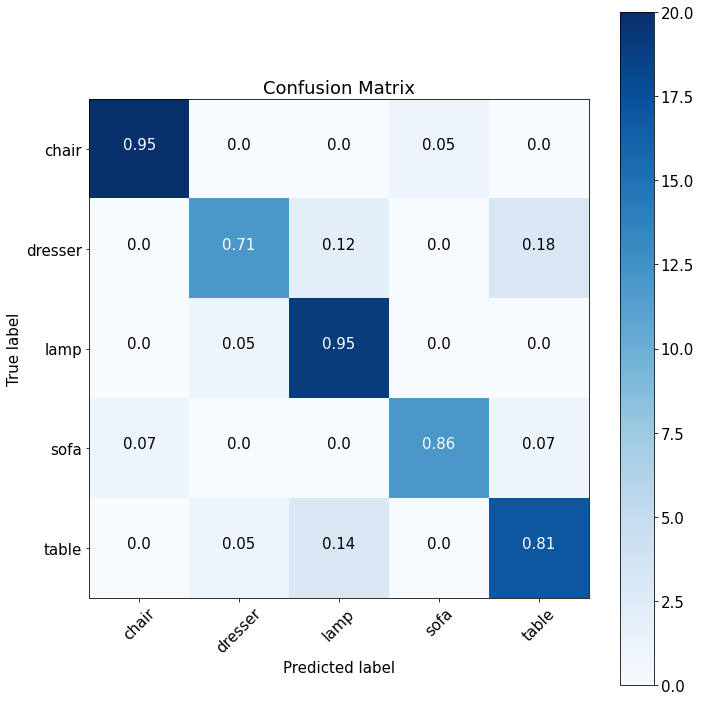

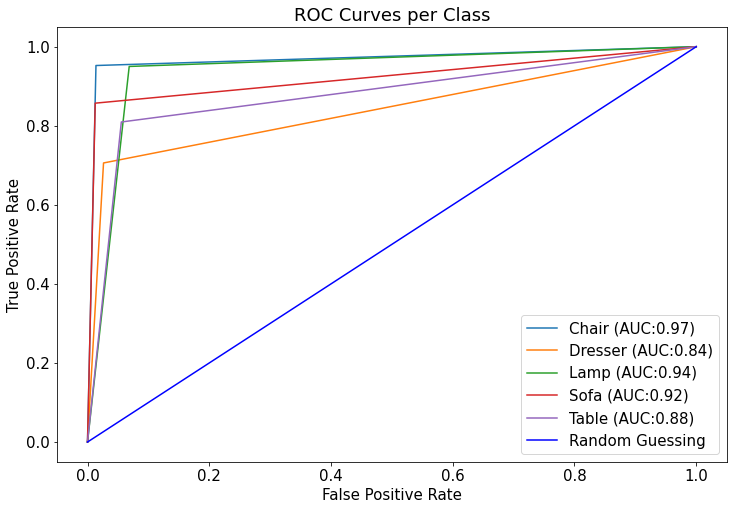

ROC AUC score: 0.9098018359537633
Classification Report
              precision    recall  f1-score   support

       chair       0.95      0.95      0.95        21
     dresser       0.86      0.71      0.77        17
        lamp       0.79      0.95      0.86        20
        sofa       0.92      0.86      0.89        14
       table       0.81      0.81      0.81        21

    accuracy                           0.86        93
   macro avg       0.87      0.85      0.86        93
weighted avg       0.86      0.86      0.86        93


-------- TERMINATED FOLD: 1 --------


In [8]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-3", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=100,
                        batch_size=32, one_fold=True, resample_data=0, augment=True)

## Experiment 4 - Deeper CNN, Longer Training

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-4-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                 

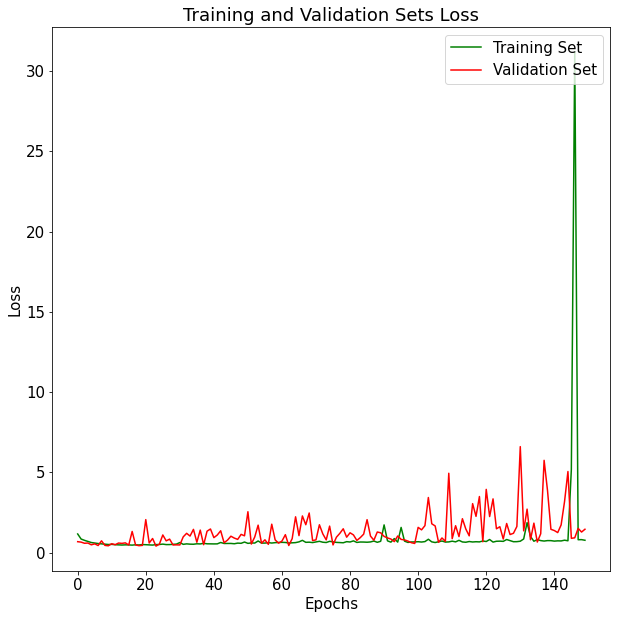

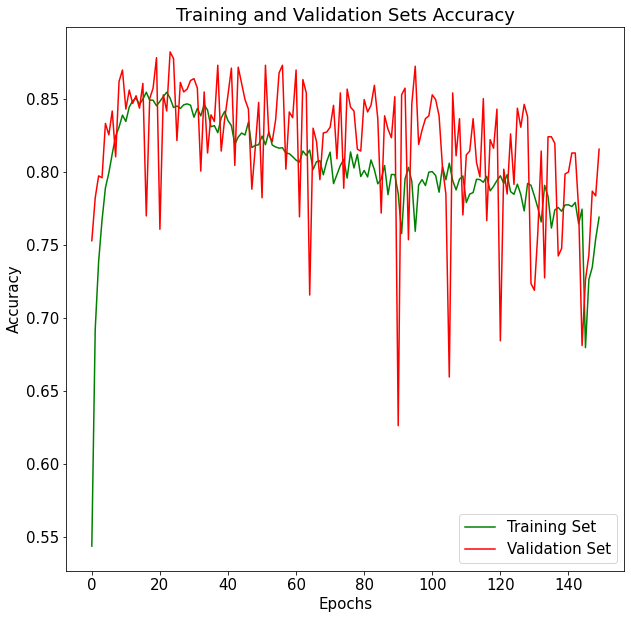

3/3 [==============================] - 0s 119ms/step - loss: 0.4262 - accuracy: 0.8387
Best model Test Loss: 0.4262479543685913
Best model Test Accuracy: 0.8387096524238586
Confusion Matrix
Normalized confusion matrix


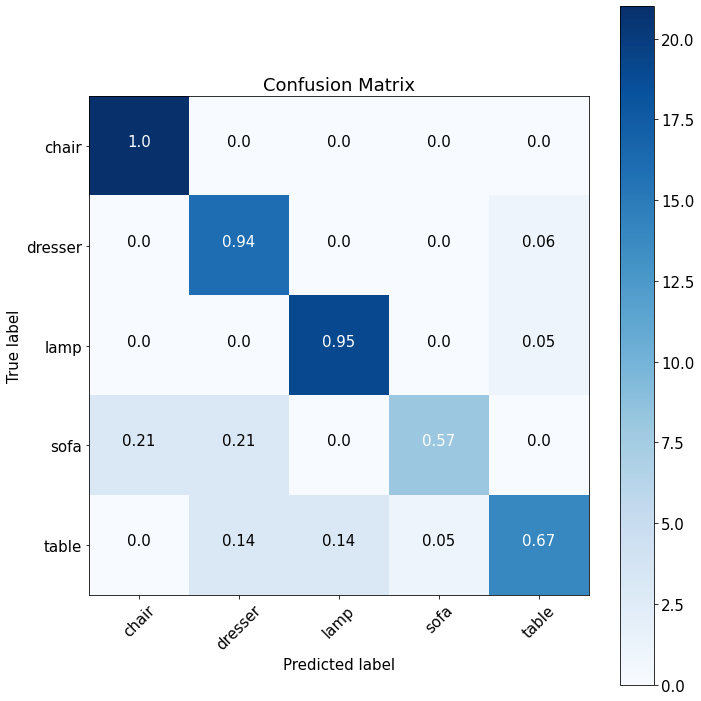

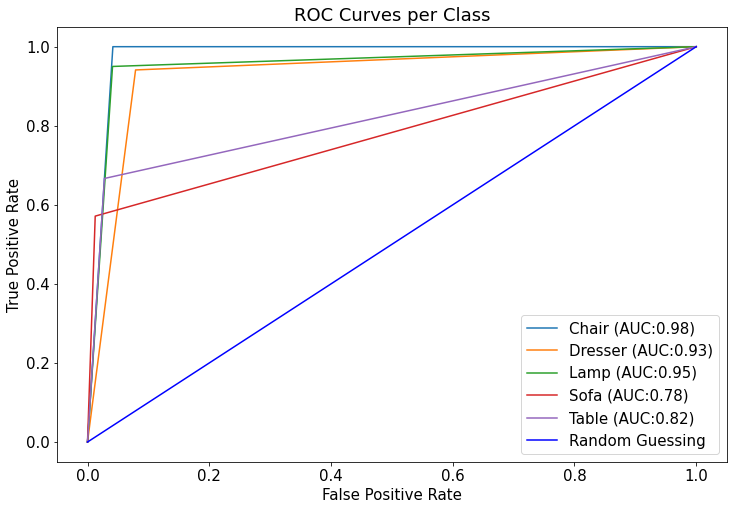

ROC AUC score: 0.8927125777558917
Classification Report
              precision    recall  f1-score   support

       chair       0.88      1.00      0.93        21
     dresser       0.73      0.94      0.82        17
        lamp       0.86      0.95      0.90        20
        sofa       0.89      0.57      0.70        14
       table       0.88      0.67      0.76        21

    accuracy                           0.84        93
   macro avg       0.85      0.83      0.82        93
weighted avg       0.85      0.84      0.83        93


-------- TERMINATED FOLD: 1 --------


In [9]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-4", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=150,
                        batch_size=32, one_fold=True, resample_data=0, augment=True)

## Experiment 5 - Larger Dense Layer, Larger Batch Size

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-5-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                 

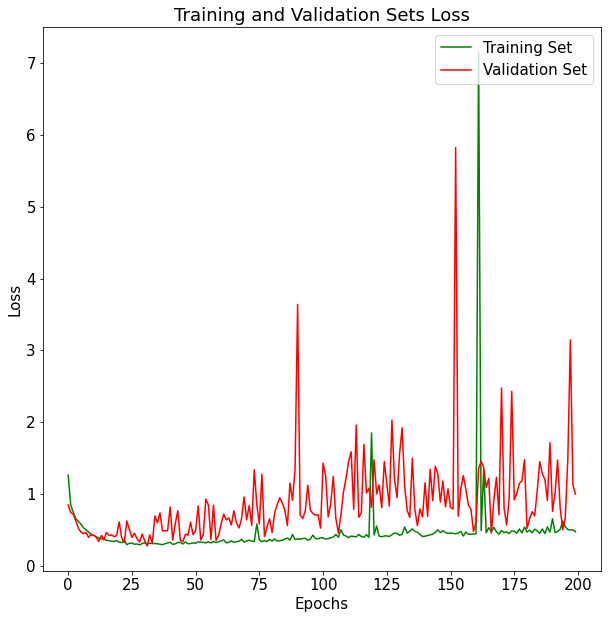

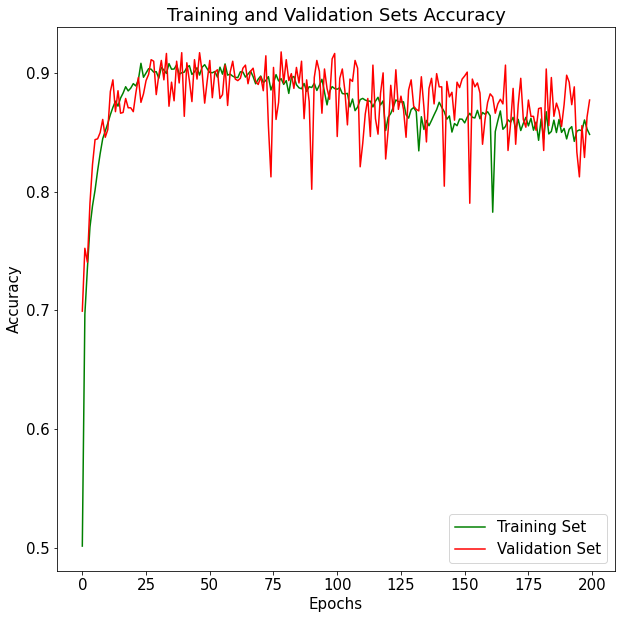

2/2 [==============================] - 0s 125ms/step - loss: 0.3355 - accuracy: 0.9032
Best model Test Loss: 0.3354920744895935
Best model Test Accuracy: 0.9032257795333862
Confusion Matrix
Normalized confusion matrix


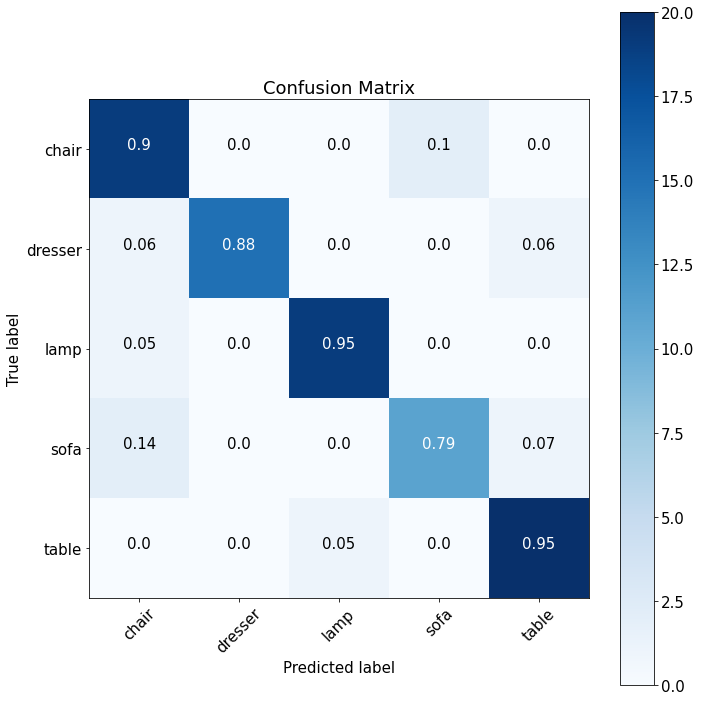

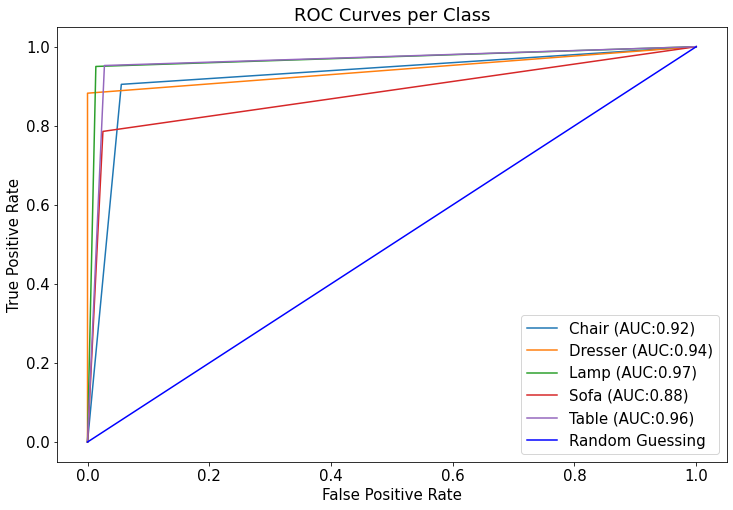

ROC AUC score: 0.935286166486709
Classification Report
              precision    recall  f1-score   support

       chair       0.83      0.90      0.86        21
     dresser       1.00      0.88      0.94        17
        lamp       0.95      0.95      0.95        20
        sofa       0.85      0.79      0.81        14
       table       0.91      0.95      0.93        21

    accuracy                           0.90        93
   macro avg       0.91      0.90      0.90        93
weighted avg       0.91      0.90      0.90        93


-------- TERMINATED FOLD: 1 --------


In [10]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-5", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=200,
                        batch_size=64, one_fold=True, resample_data=0, augment=True)

## Experiment 6 - Learning Rate Decay: Step Decay

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.


2022-02-15 17:23:46.100389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 17:23:46.124261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 17:23:46.124373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 17:23:46.124837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "Experiment-6-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)   

2022-02-15 17:23:48.239975: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-02-15 17:23:48.957168: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


120/120 [==============================] - ETA: 0s - loss: 1.3792 - accuracy: 0.4434
Epoch 00001: val_loss improved from inf to 1.25695, saving model to saved_models/images/Experiment-6/Experiment-6-fold-1.h5
120/120 [==============================] - 46s 368ms/step - loss: 1.3792 - accuracy: 0.4434 - val_loss: 1.2569 - val_accuracy: 0.5797 - lr: 0.0010
Epoch 2/200
120/120 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.6391
Epoch 00002: val_loss improved from 1.25695 to 0.69932, saving model to saved_models/images/Experiment-6/Experiment-6-fold-1.h5
120/120 [==============================] - 43s 362ms/step - loss: 0.9770 - accuracy: 0.6391 - val_loss: 0.6993 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 3/200
120/120 [==============================] - ETA: 0s - loss: 0.8196 - accuracy: 0.7034
Epoch 00003: val_loss improved from 0.69932 to 0.59232, saving model to saved_models/images/Experiment-6/Experiment-6-fold-1.h5
120/120 [==============================] - 45s 

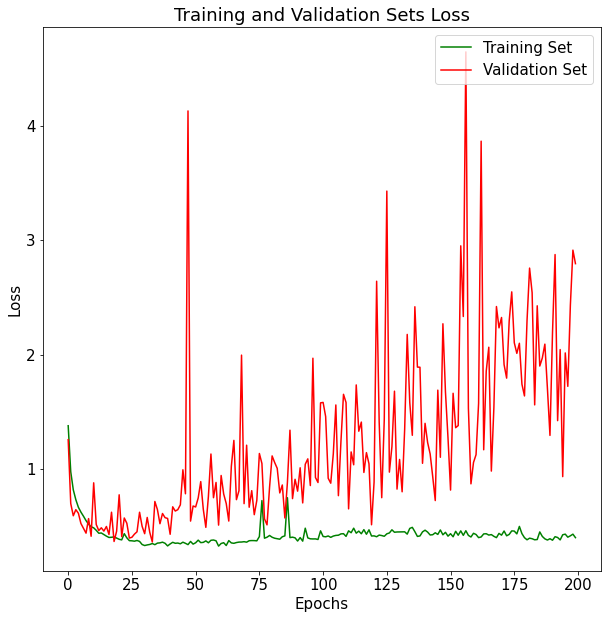

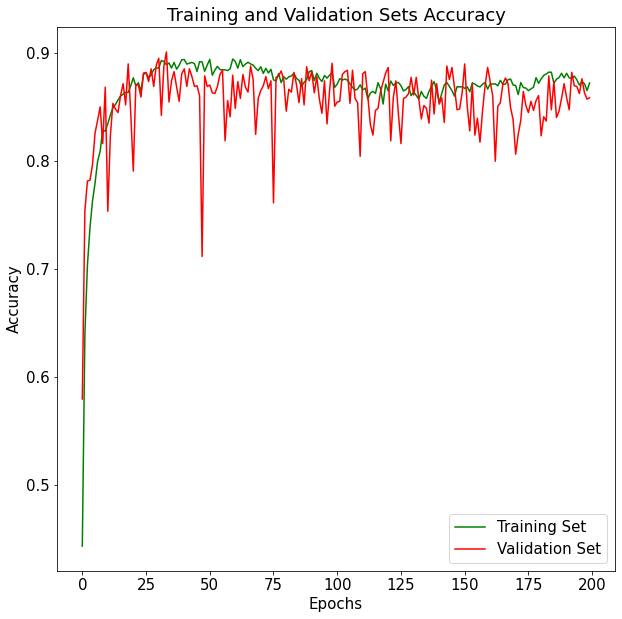

2/2 [==============================] - 0s 162ms/step - loss: 0.3511 - accuracy: 0.9247
Best model Test Loss: 0.3510754108428955
Best model Test Accuracy: 0.9247311949729919
Confusion Matrix
Normalized confusion matrix


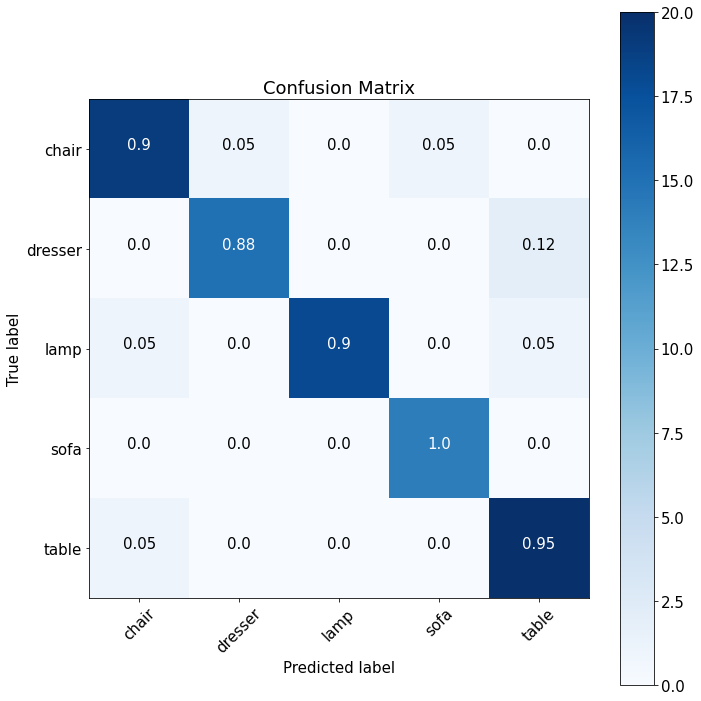

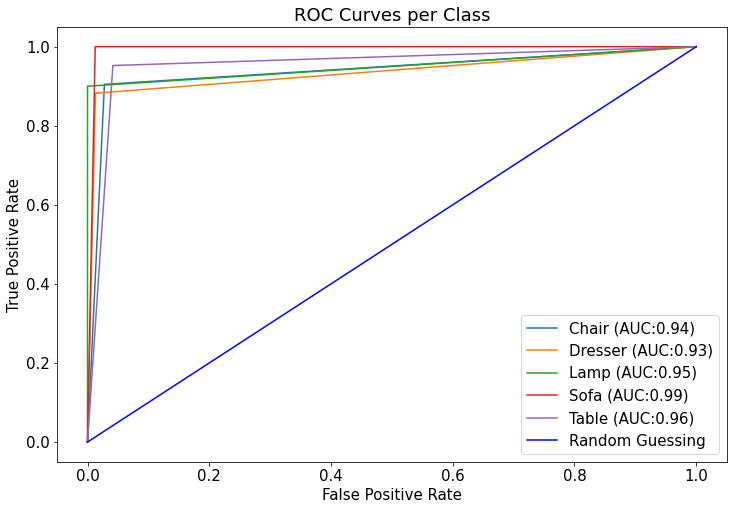

ROC AUC score: 0.954423523128994


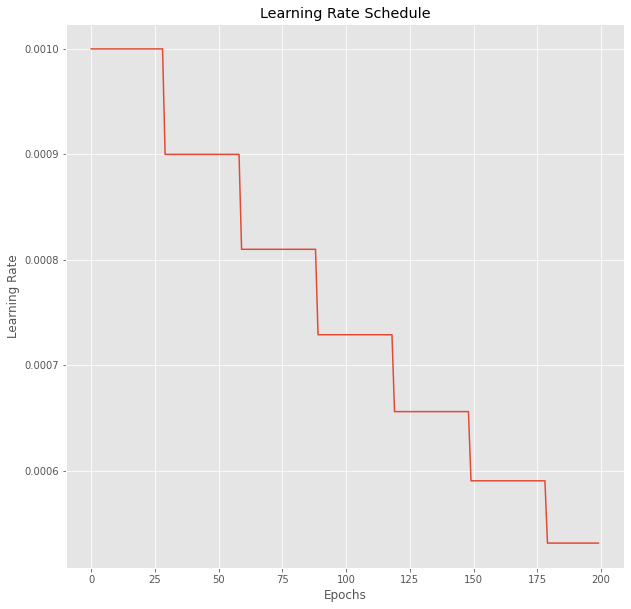

Classification Report
              precision    recall  f1-score   support

       chair       0.90      0.90      0.90        21
     dresser       0.94      0.88      0.91        17
        lamp       1.00      0.90      0.95        20
        sofa       0.93      1.00      0.97        14
       table       0.87      0.95      0.91        21

    accuracy                           0.92        93
   macro avg       0.93      0.93      0.93        93
weighted avg       0.93      0.92      0.92        93


-------- TERMINATED FOLD: 1 --------


In [5]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-6", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=200,
                        batch_size=64, one_fold=True, resample_data=0, augment=True)

## Experiment 7 - Larger Kernel, Early Stopping
#### Increased the size of the Kernel of the first two convolutional layers in the attempt of capturing bigger features.
#### Stride was not used in order to avoid any possible loss of accuracy.
#### Early stopping is set at `min_delta=0.001, patience=100`, i.e. an improvement of 0.1% for 100 epochs of training. Max Epochs: 300

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.


2022-02-15 23:52:44.725128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 23:52:44.743553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 23:52:44.743667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 23:52:44.744316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "Experiment-7-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 128)   

2022-02-15 23:52:46.880567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-02-15 23:52:47.600261: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


120/120 [==============================] - ETA: 0s - loss: 1.3465 - accuracy: 0.4517
Epoch 00001: val_loss improved from inf to 0.86557, saving model to saved_models/images/Experiment-7/Experiment-7-fold-1.h5
120/120 [==============================] - 46s 372ms/step - loss: 1.3465 - accuracy: 0.4517 - val_loss: 0.8656 - val_accuracy: 0.6765 - lr: 0.0010
Epoch 2/300
120/120 [==============================] - ETA: 0s - loss: 0.9591 - accuracy: 0.6357
Epoch 00002: val_loss improved from 0.86557 to 0.71973, saving model to saved_models/images/Experiment-7/Experiment-7-fold-1.h5
120/120 [==============================] - 44s 367ms/step - loss: 0.9591 - accuracy: 0.6357 - val_loss: 0.7197 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 3/300
120/120 [==============================] - ETA: 0s - loss: 0.8462 - accuracy: 0.6850
Epoch 00003: val_loss did not improve from 0.71973
120/120 [==============================] - 45s 373ms/step - loss: 0.8462 - accuracy: 0.6850 - val_loss: 0.8244 - val_accurac

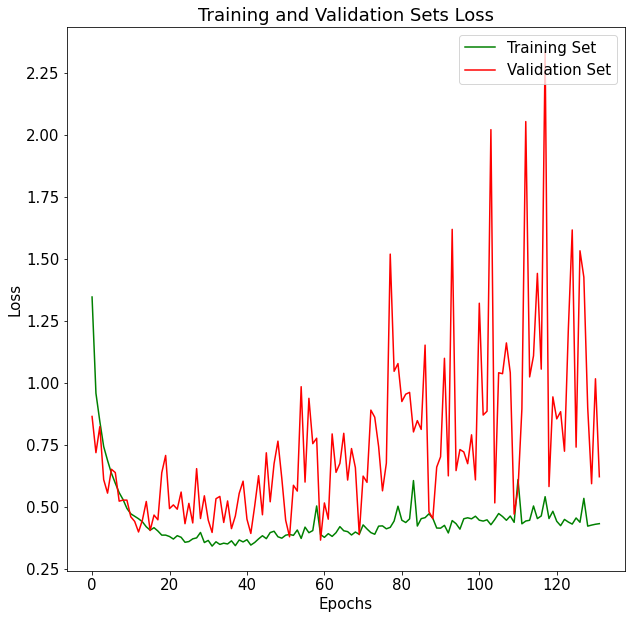

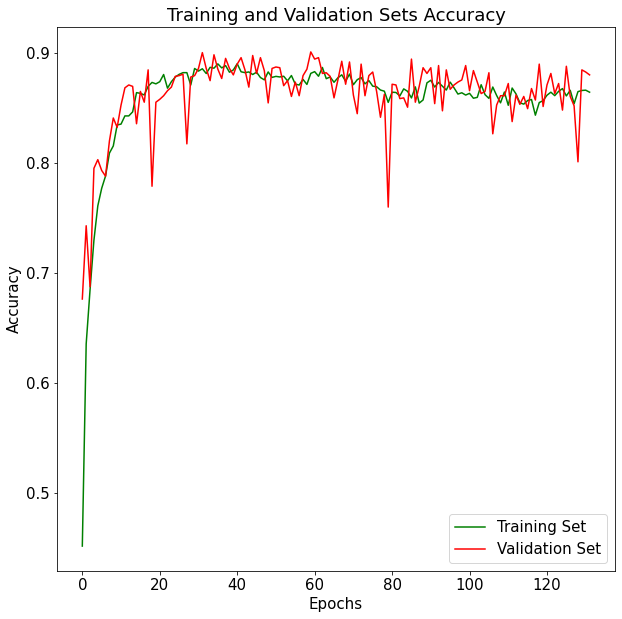

2/2 [==============================] - 0s 167ms/step - loss: 0.3687 - accuracy: 0.8925
Best model Test Loss: 0.3687441051006317
Best model Test Accuracy: 0.8924731016159058
Confusion Matrix
Normalized confusion matrix


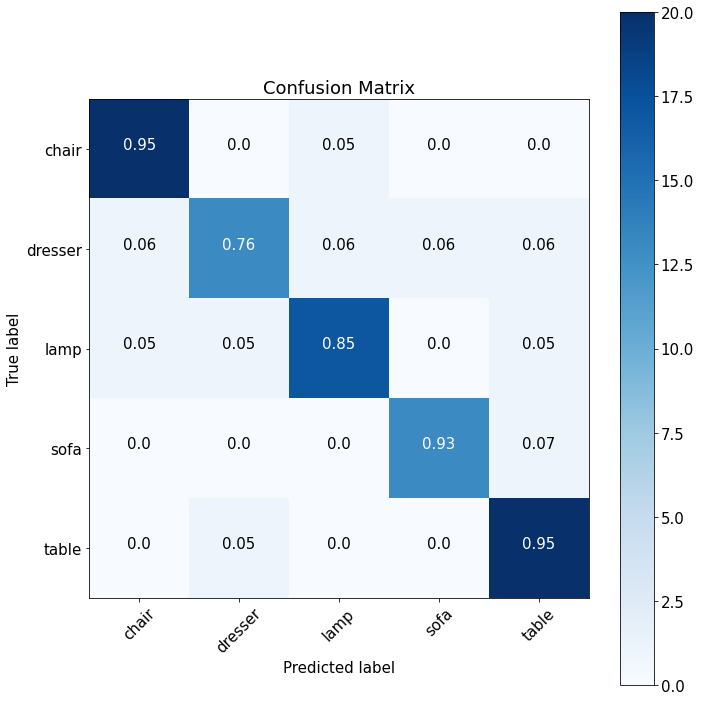

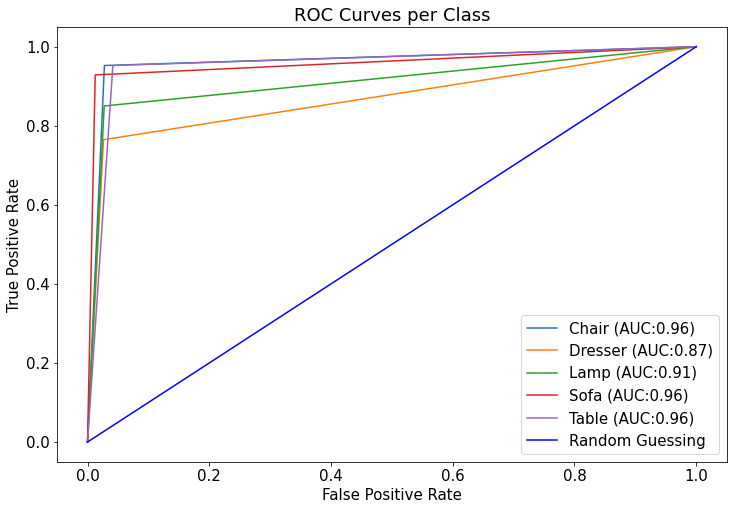

ROC AUC score: 0.9312223493646072


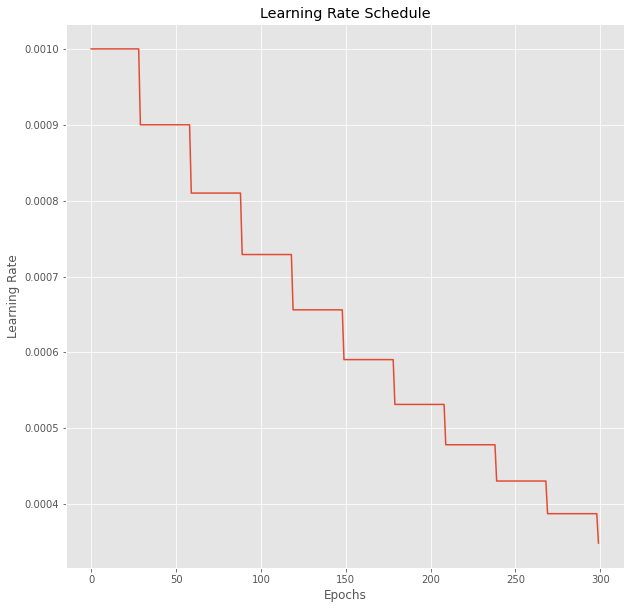

Classification Report
              precision    recall  f1-score   support

       chair       0.91      0.95      0.93        21
     dresser       0.87      0.76      0.81        17
        lamp       0.89      0.85      0.87        20
        sofa       0.93      0.93      0.93        14
       table       0.87      0.95      0.91        21

    accuracy                           0.89        93
   macro avg       0.89      0.89      0.89        93
weighted avg       0.89      0.89      0.89        93


-------- TERMINATED FOLD: 1 --------


In [5]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-7", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=300,
                        batch_size=64, one_fold=True, resample_data=0, augment=True)

## Experiment 8 (A) - Regularization
#### Early stopping is set at `min_delta=0.001, patience=50`.

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-8-1-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                               

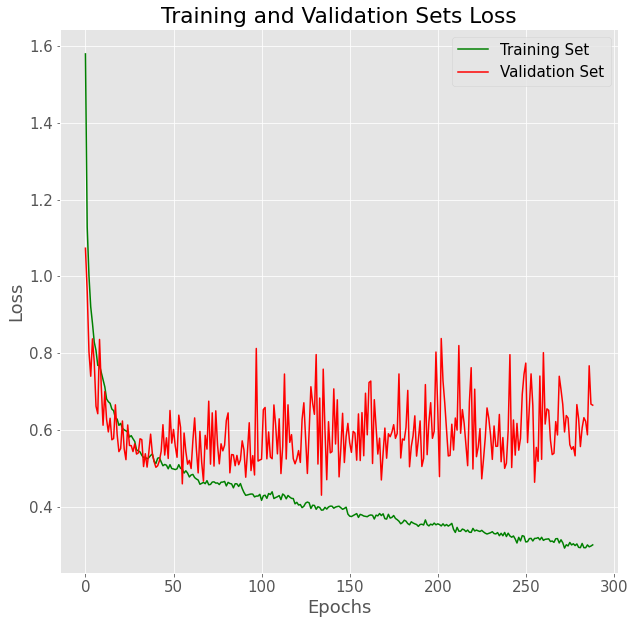

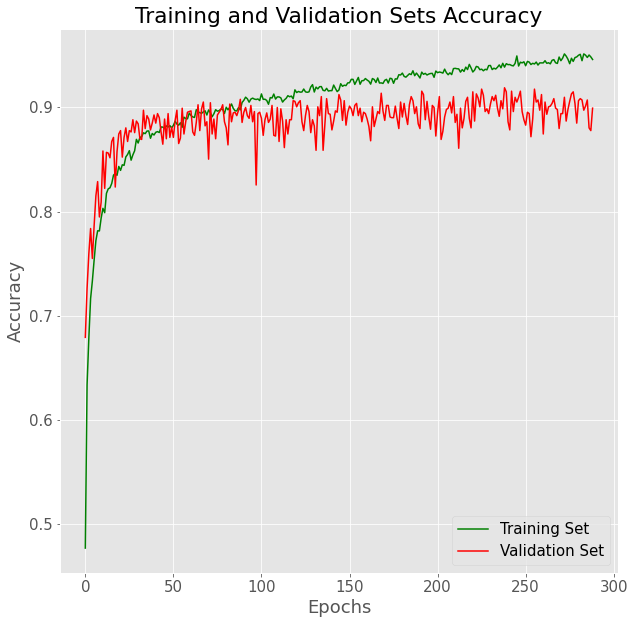

2/2 [==============================] - 0s 111ms/step - loss: 0.3466 - accuracy: 0.9355
Best model Test Loss: 0.3466363847255707
Best model Test Accuracy: 0.9354838728904724
Confusion Matrix
Normalized confusion matrix


/tmp/ipykernel_78078/503241339.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


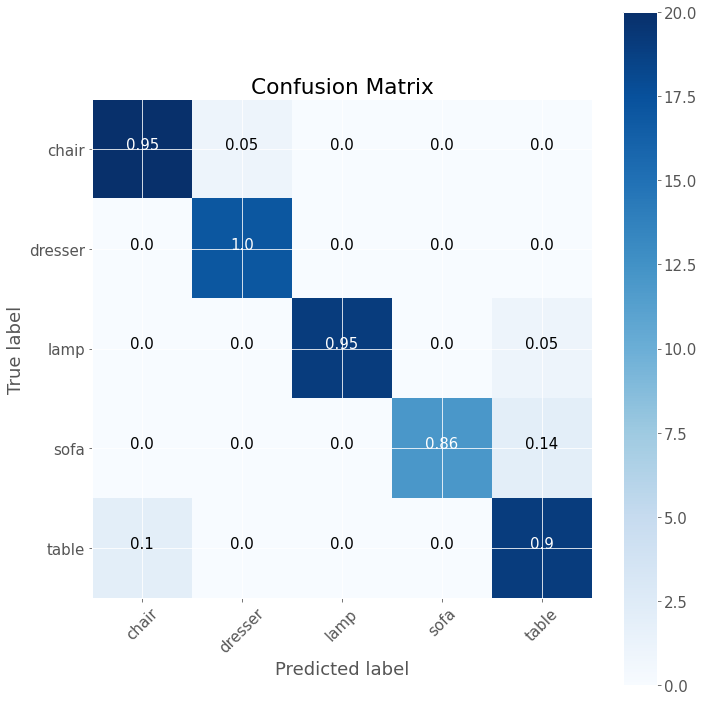

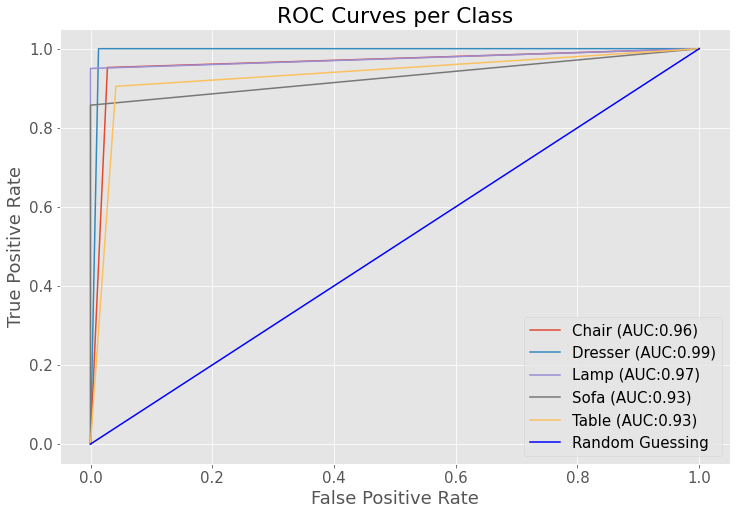

ROC AUC score: 0.958168337510443


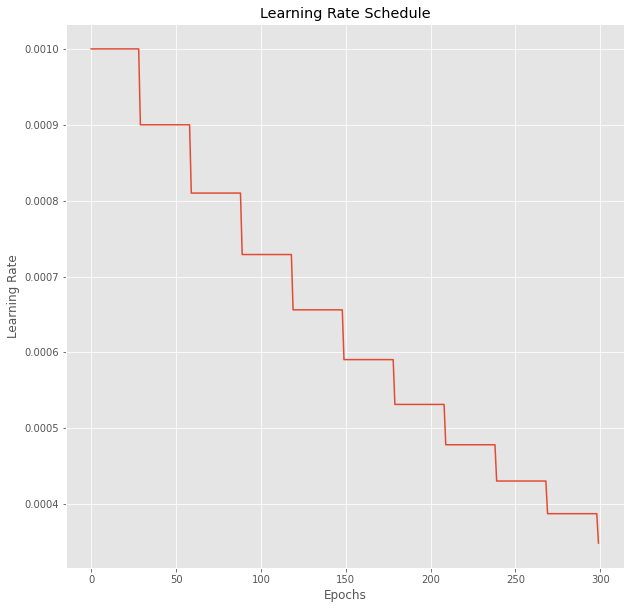

Classification Report
              precision    recall  f1-score   support

       chair       0.91      0.95      0.93        21
     dresser       0.94      1.00      0.97        17
        lamp       1.00      0.95      0.97        20
        sofa       1.00      0.86      0.92        14
       table       0.86      0.90      0.88        21

    accuracy                           0.94        93
   macro avg       0.94      0.93      0.94        93
weighted avg       0.94      0.94      0.94        93


-------- TERMINATED FOLD: 1 --------


In [10]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(l=0.001), input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(l=0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-8-1", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=300,
                        batch_size=64, one_fold=True, resample_data=0, augment=True)

## Experiment 8 (B) - Lower Regularization Factor
#### Early stopping is set at `min_delta=0.001, patience=50`.

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-8-2-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 64)       0         
 2D)                                                             
                               

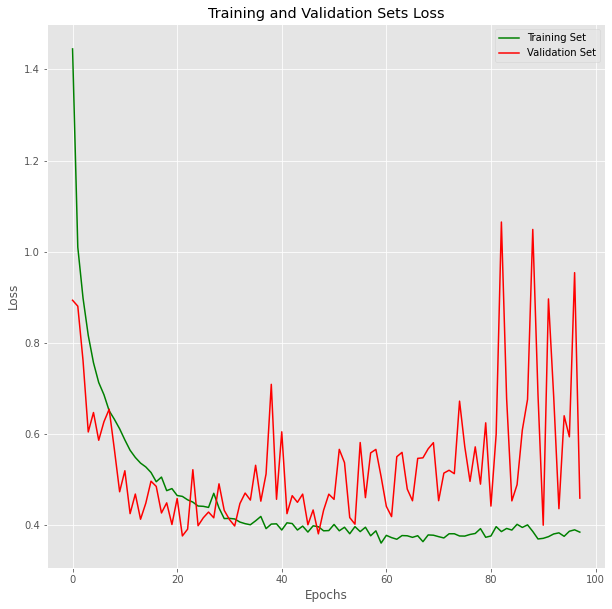

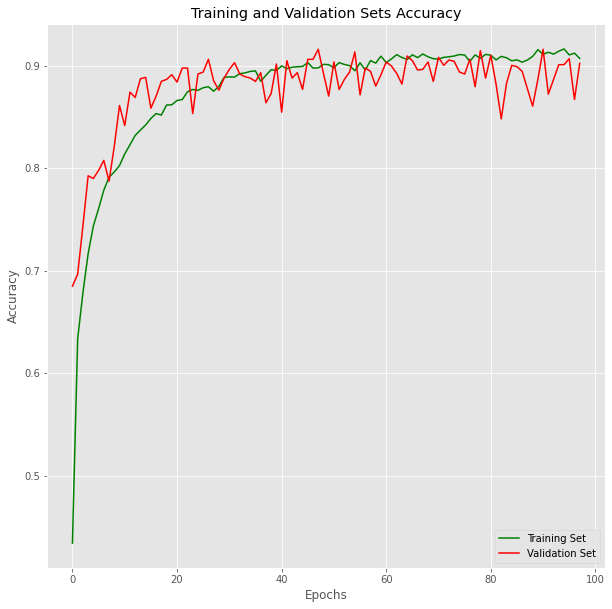

2/2 [==============================] - 0s 129ms/step - loss: 0.3496 - accuracy: 0.9140
Best model Test Loss: 0.34962570667266846
Best model Test Accuracy: 0.9139785170555115
Confusion Matrix
Normalized confusion matrix


/tmp/ipykernel_78078/503241339.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


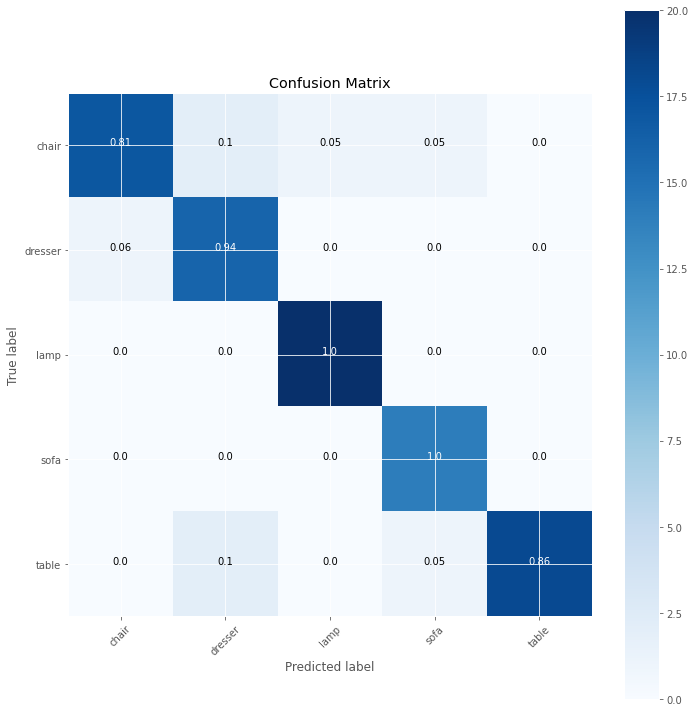

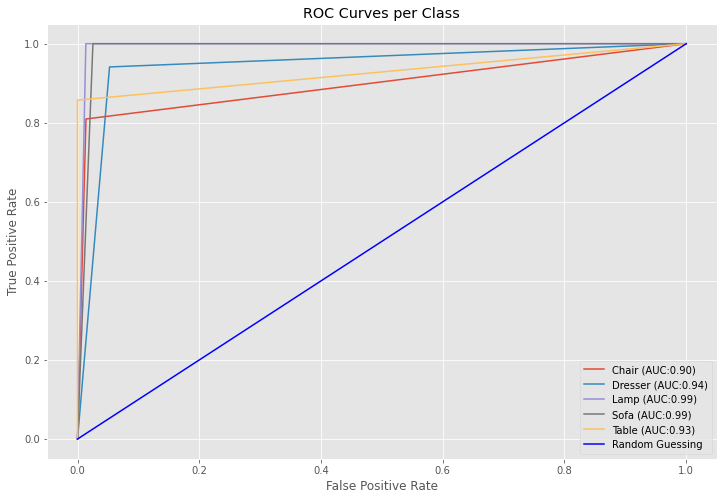

ROC AUC score: 0.9502307583585455


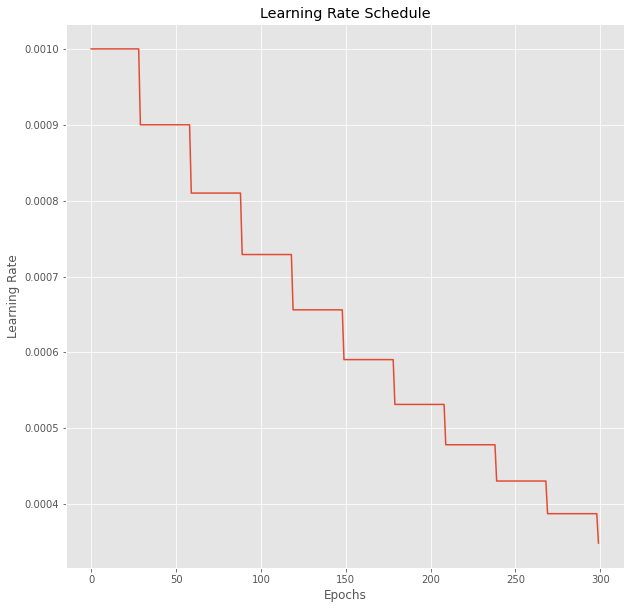

Classification Report
              precision    recall  f1-score   support

       chair       0.94      0.81      0.87        21
     dresser       0.80      0.94      0.86        17
        lamp       0.95      1.00      0.98        20
        sofa       0.88      1.00      0.93        14
       table       1.00      0.86      0.92        21

    accuracy                           0.91        93
   macro avg       0.91      0.92      0.91        93
weighted avg       0.92      0.91      0.91        93


-------- TERMINATED FOLD: 1 --------


In [11]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001), input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-8-2", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=300,
                        batch_size=64, one_fold=True, resample_data=0, augment=True)

## Experiment 9 - Batch Normalization
#### Early stopping is set at `min_delta=0.001, patience=50`.

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-9-1-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                               

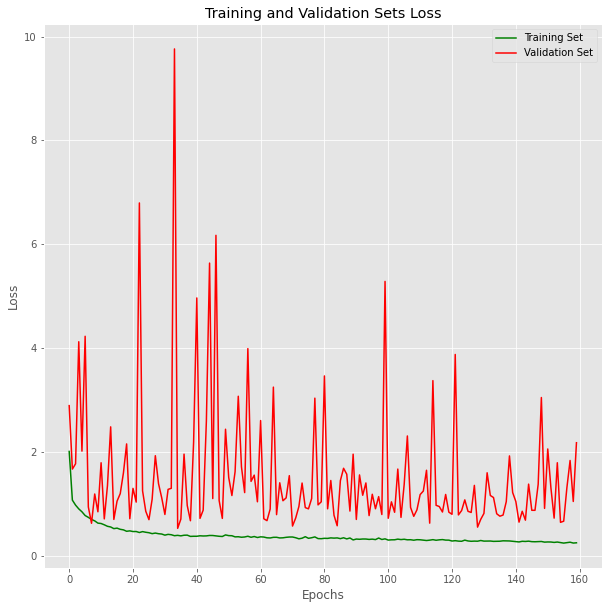

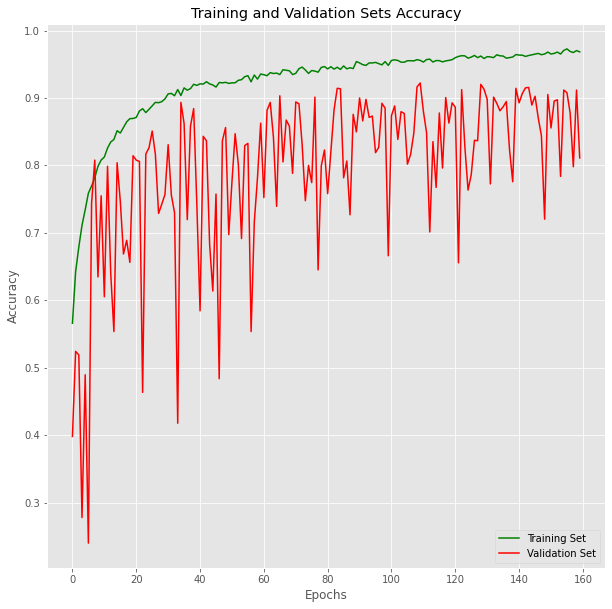

1/1 [==============================] - 0s 451ms/step - loss: 0.4233 - accuracy: 0.9355
Best model Test Loss: 0.4232884347438812
Best model Test Accuracy: 0.9354838728904724
Confusion Matrix
Normalized confusion matrix


/tmp/ipykernel_78078/503241339.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


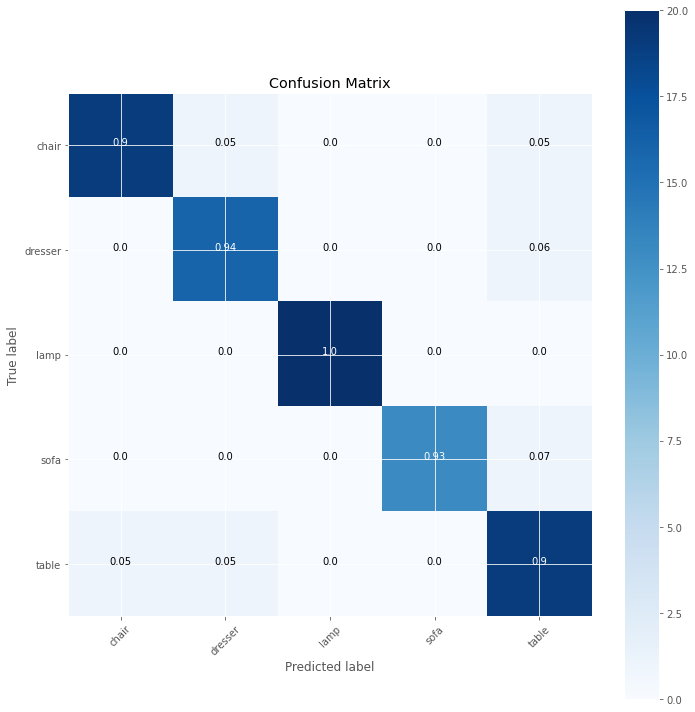

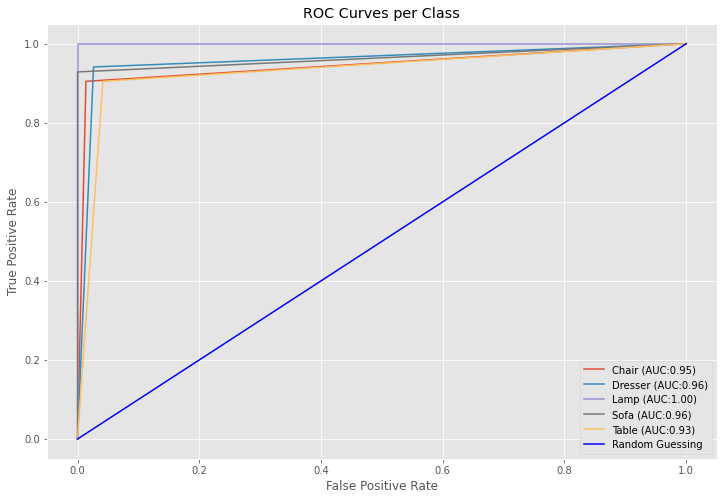

ROC AUC score: 0.9597400363654234


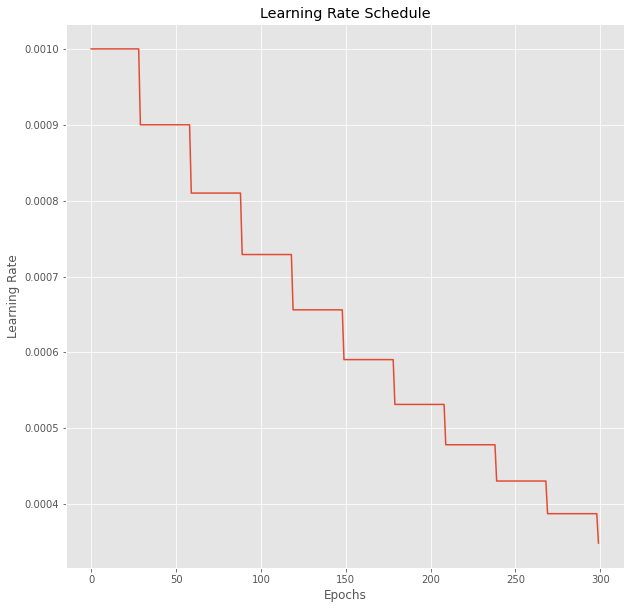

Classification Report
              precision    recall  f1-score   support

       chair       0.95      0.90      0.93        21
     dresser       0.89      0.94      0.91        17
        lamp       1.00      1.00      1.00        20
        sofa       1.00      0.93      0.96        14
       table       0.86      0.90      0.88        21

    accuracy                           0.94        93
   macro avg       0.94      0.94      0.94        93
weighted avg       0.94      0.94      0.94        93


-------- TERMINATED FOLD: 1 --------


In [12]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-9-1", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=300,
                        batch_size=128, one_fold=True, resample_data=0, augment=True)

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.
Model: "Experiment-9-2-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                               

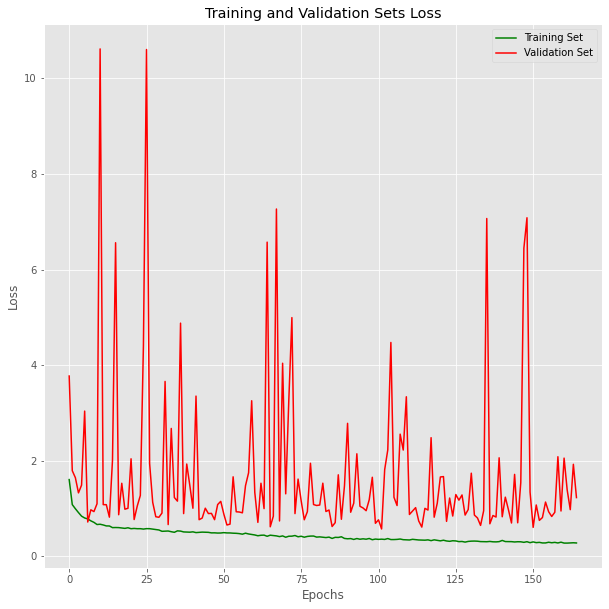

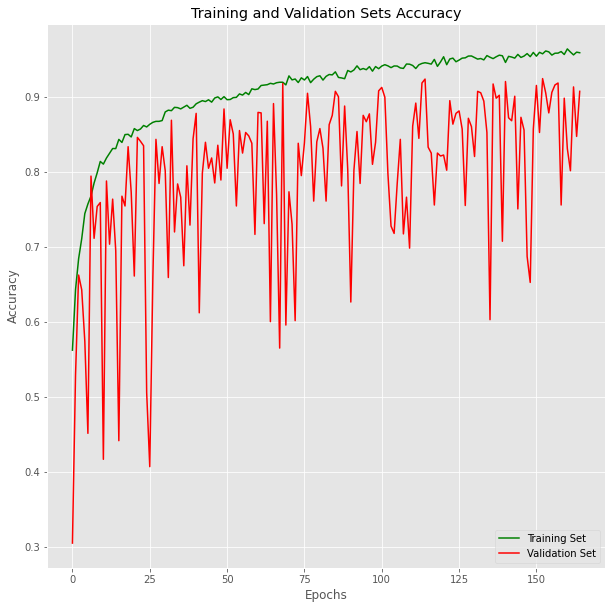

2/2 [==============================] - 0s 119ms/step - loss: 0.4716 - accuracy: 0.8602
Best model Test Loss: 0.47155115008354187
Best model Test Accuracy: 0.8602150678634644
Confusion Matrix
Normalized confusion matrix


/tmp/ipykernel_78078/503241339.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


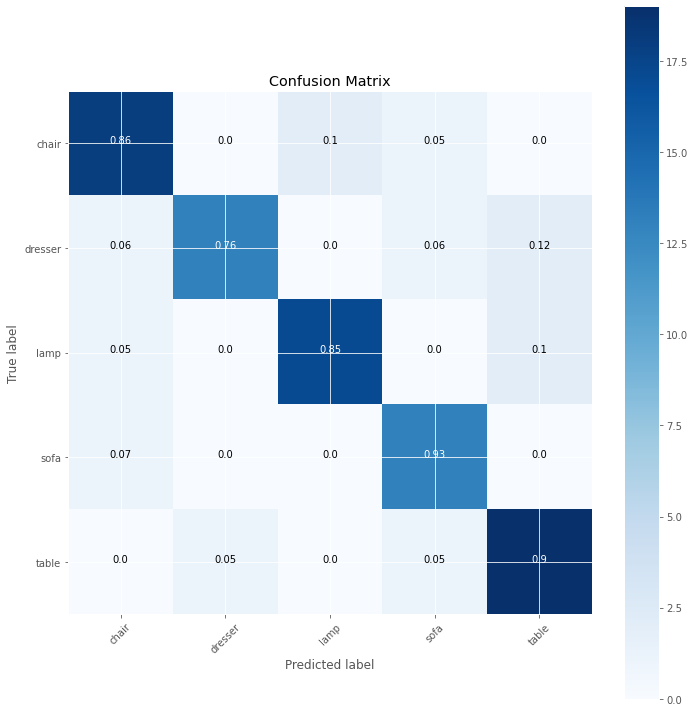

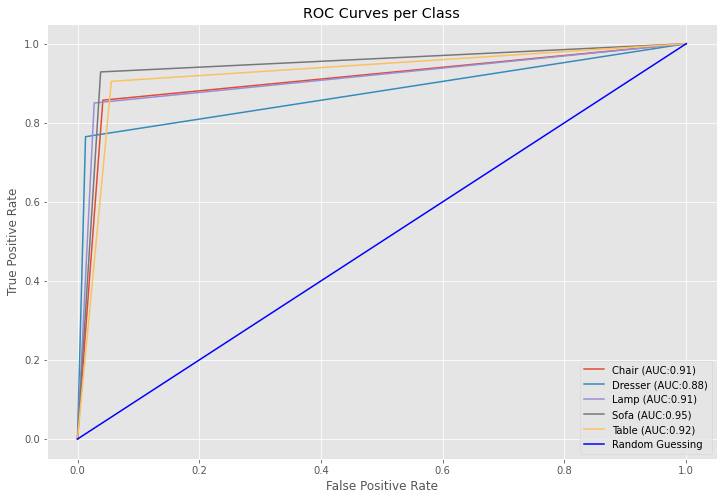

ROC AUC score: 0.9129430012051791


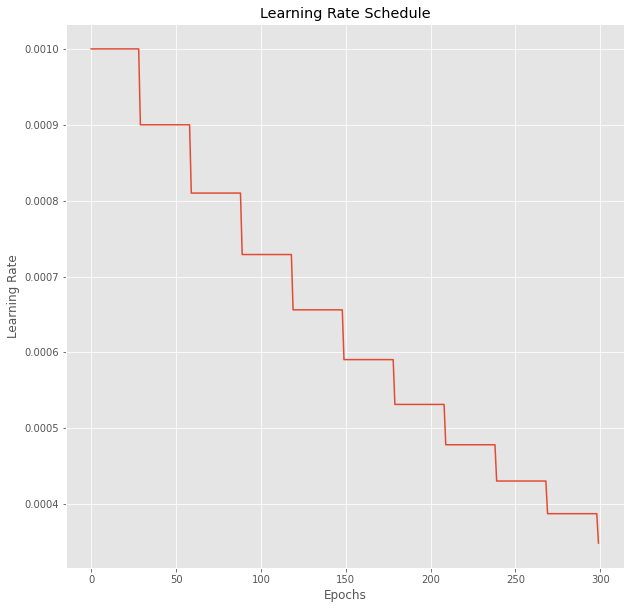

Classification Report
              precision    recall  f1-score   support

       chair       0.86      0.86      0.86        21
     dresser       0.93      0.76      0.84        17
        lamp       0.89      0.85      0.87        20
        sofa       0.81      0.93      0.87        14
       table       0.83      0.90      0.86        21

    accuracy                           0.86        93
   macro avg       0.86      0.86      0.86        93
weighted avg       0.86      0.86      0.86        93


-------- TERMINATED FOLD: 1 --------


In [13]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-9-2", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=300,
                        batch_size=64, one_fold=True, resample_data=0, augment=True)

Found 93 validated image filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 7647 validated image filenames belonging to 5 classes.
Found 1530 validated image filenames belonging to 5 classes.


2022-02-16 10:15:08.479070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 10:15:08.514674: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 10:15:08.514790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 10:15:08.515394: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "Experiment-9-3-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 59, 59, 64)       256       
 hNormalization)                                                 
                                                  

2022-02-16 10:15:10.772176: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


  1/239 [..............................] - ETA: 9:53 - loss: 3.4715 - accuracy: 0.2188

2022-02-16 10:15:11.690231: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


239/239 [==============================] - ETA: 0s - loss: 1.5201 - accuracy: 0.5645
Epoch 00001: val_loss improved from inf to 2.87331, saving model to saved_models/images/Experiment-9-3/Experiment-9-3-fold-1.h5
239/239 [==============================] - 48s 193ms/step - loss: 1.5201 - accuracy: 0.5645 - val_loss: 2.8733 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 2/300
239/239 [==============================] - ETA: 0s - loss: 1.1516 - accuracy: 0.6396
Epoch 00002: val_loss improved from 2.87331 to 1.77020, saving model to saved_models/images/Experiment-9-3/Experiment-9-3-fold-1.h5
239/239 [==============================] - 44s 183ms/step - loss: 1.1516 - accuracy: 0.6396 - val_loss: 1.7702 - val_accuracy: 0.6359 - lr: 0.0010
Epoch 3/300
239/239 [==============================] - ETA: 0s - loss: 1.0242 - accuracy: 0.6906
Epoch 00003: val_loss improved from 1.77020 to 1.10110, saving model to saved_models/images/Experiment-9-3/Experiment-9-3-fold-1.h5
239/239 [==========================

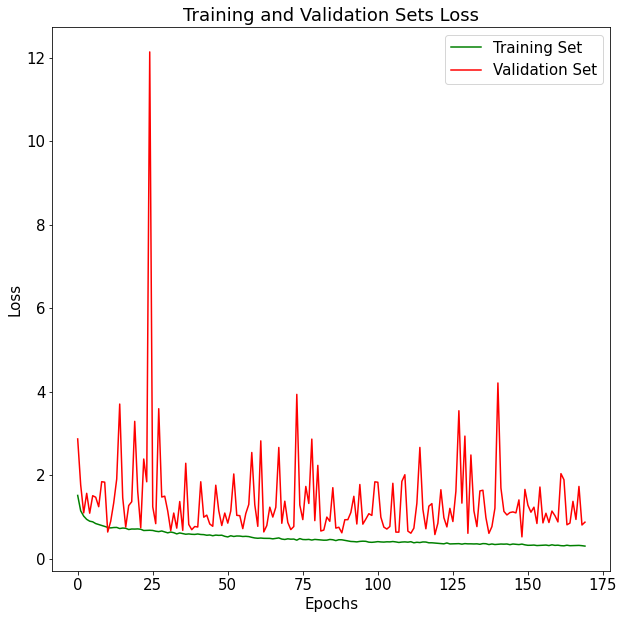

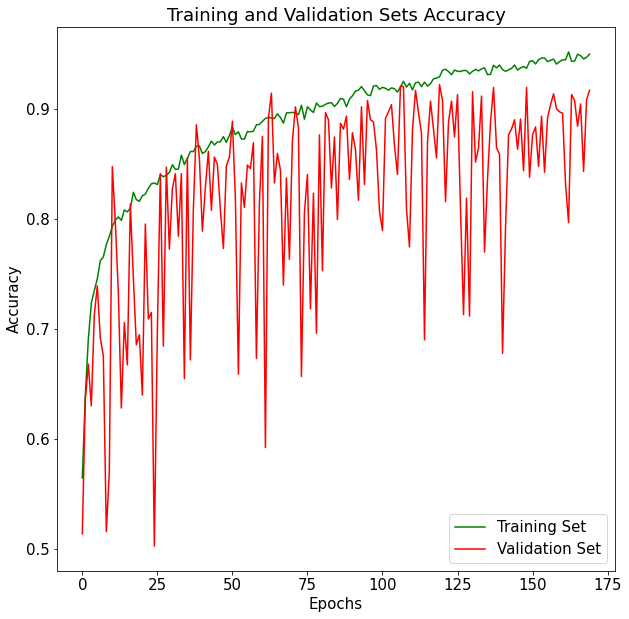

3/3 [==============================] - 0s 144ms/step - loss: 0.3964 - accuracy: 0.9355
Best model Test Loss: 0.3964293301105499
Best model Test Accuracy: 0.9354838728904724
Confusion Matrix
Normalized confusion matrix


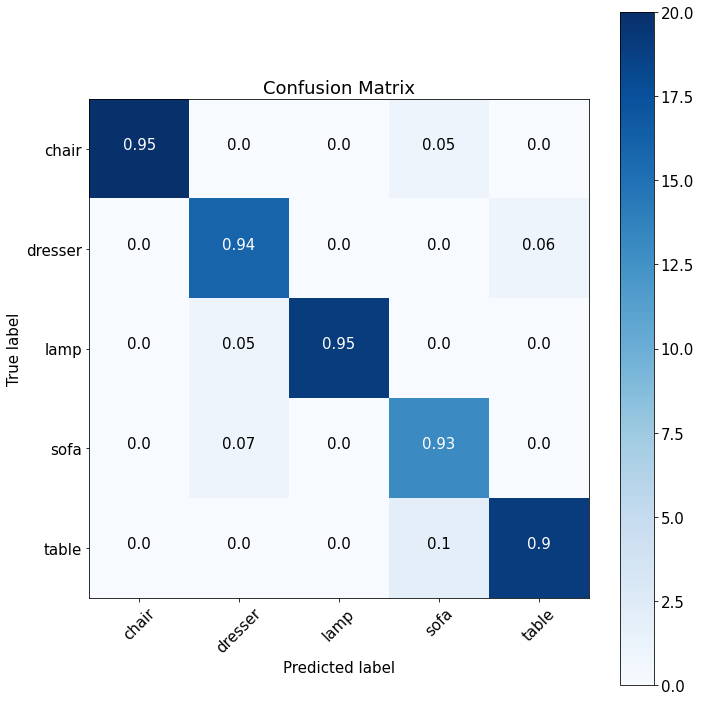

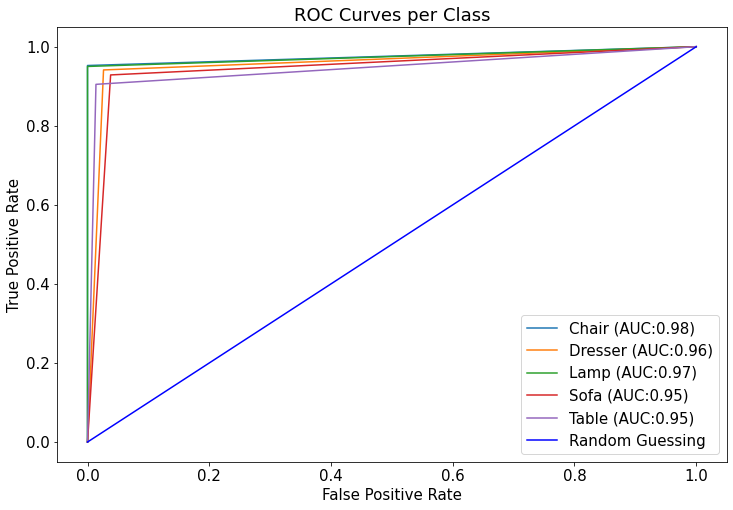

ROC AUC score: 0.9598711394395645


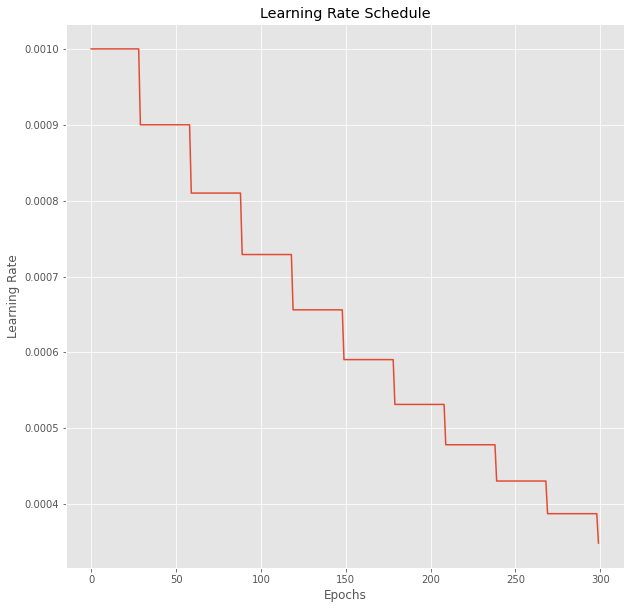

Classification Report
              precision    recall  f1-score   support

       chair       1.00      0.95      0.98        21
     dresser       0.89      0.94      0.91        17
        lamp       1.00      0.95      0.97        20
        sofa       0.81      0.93      0.87        14
       table       0.95      0.90      0.93        21

    accuracy                           0.94        93
   macro avg       0.93      0.94      0.93        93
weighted avg       0.94      0.94      0.94        93


-------- TERMINATED FOLD: 1 --------


In [5]:
# experiment model layers
layers = [
    Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001), input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l=0.0001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
]

# train, validate and test
images_kfold_validation_layers(model_name="Experiment-9-3", n_splits=6, test_size=0.01,
                        shuffle=True, layers=layers, learning_rate=0.001,
                        decay=1e-6, target_size=TARGET_SIZE, epochs=300,
                        batch_size=32, one_fold=True, resample_data=0, augment=True)